# Graph on BFS

test script to try bulding a graph on top of the face heads

## import

In [1]:
import os
import numpy as np
import tensorflow as tf

from utils.load_config import load_config
from utils.load_data import load_data
from utils.extraction_model import load_extraction_model
from utils.PatternFeatureReduction import PatternFeatureSelection
from utils.patches import compute_center_of_activity

import matplotlib.pyplot as plt

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True, linewidth=150)

# Set parameters

In [2]:
# define configuration
config_path = 'GR_t02_graph_on_BFS_m0001.json'

# declare parameters
best_eyes_IoU_ft = [161, 114, 229, 82,19, 125, 136]
best_nose_IoU_ft = [101, 52, 172, 210, 167, 216, 85, 102, 232, 4, 77, 162, 1,33, 208, 29, 30, 93, 59, 104, 23, 133, 161, 115, 19, 81, 74, 97, 148, 120, 221, 9, 103, 149, 246, 150, 137, 226, 34, 233, 229, 54, 31, 242, 37, 155, 171, 255, 235, 124, 224, 196, 227, 27, 241, 107, 228, 211, 243, 166, 20]

# load config
config = load_config(config_path, path='../../configs/graph')

# create directory if non existant
save_path = os.path.join("../../models/saved", config["config_name"])
if not os.path.exists(save_path):
    os.mkdir(save_path)

# load extraction pipeline

In [3]:
# load and define model
v4_model = load_extraction_model(config, input_shape=tuple(config["input_shape"]))
v4_model = tf.keras.Model(inputs=v4_model.input, outputs=v4_model.get_layer(config['v4_layer']).output)
size_ft = tuple(np.shape(v4_model.output)[1:3])
print("[LOAD] size_ft", size_ft)
print("[LOAD] Model loaded")

1Metal device set to: Apple M1 Pro
 Physical GPUs, 1 Logical GPUs


2022-07-13 16:36:32.207636: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-13 16:36:32.207757: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[LOAD] size_ft (56, 56)
[LOAD] Model loaded


# load data

In [4]:
data = load_data(config)
print("[LOAD] Data loaded", np.shape(data[0]))
print()

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 3/3 [00:00<00:00, 151.29it/s]

[LOAD] Data loaded (3, 224, 224, 3)



In [5]:
# plot images
def plot_images(data, lmk_pos=None, lmk_colors=None, n_max_col=7, size_img=4, title=None):
    n_image = len(data[0])

    # compute n_row and n_col
    n_col = np.min([n_max_col, n_image])
    n_row = int(n_image / n_col)

    # declare figure
    plt.figure(figsize=(size_img*n_col, size_img*n_row))
    for i in range(n_row):
        for j in range(n_col):
            if title is not None:
                plt.title(title)

            img_idx = i * n_col + j
            plt.subplot(n_row, n_col, img_idx + 1)
            img = np.array(data[0][img_idx] + 128)/256
            rgb_img = img[..., ::-1]
            rgb_img[rgb_img > 1] = 1.0
            rgb_img = np.array(rgb_img)

            if lmk_pos is not None:
                if lmk_colors is not None:
                    for p, pos in enumerate(lmk_pos):
                        rgb_img[pos[1], pos[0]] = lmk_colors[p]
                else:
                    for pos in lmk_pos:
                        rgb_img[pos[1], pos[0]] = [1, 0, 0]

            plt.imshow(rgb_img)


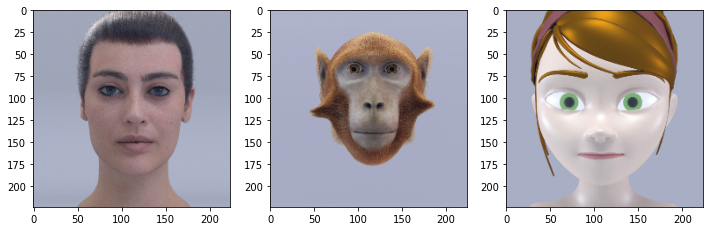

In [6]:
plot_images(data)

# predict with extraction pipeline

In [7]:
def predict_v4(data):
    # predict v4 output
    preds = v4_model.predict(data[0], verbose=1)
    print("[predict_v4] shape prediction", np.shape(preds))

    # get feature maps that mimic a semantic selection pipeline
    # keep only highest IoU semantic score
    eyebrow_preds = preds[..., best_eyes_IoU_ft]
    print("[predict_v4] shape eyebrow semantic feature selection", np.shape(eyebrow_preds))
    lips_preds = preds[..., best_nose_IoU_ft]
    print("[predict_v4] shape lips semantic feature selection", np.shape(lips_preds))
    preds = np.concatenate((eyebrow_preds, lips_preds), axis=3)
    print("[predict_v4] shape preds", np.shape(preds))

    return preds

In [8]:
preds = predict_v4(data)

1/1 [==============================] - 0s 82ms/step
[predict_v4] shape prediction (3, 56, 56, 256)
[predict_v4] shape eyebrow semantic feature selection (3, 56, 56, 7)
[predict_v4] shape lips semantic feature selection (3, 56, 56, 61)
[predict_v4] shape preds (3, 56, 56, 68)


2022-07-13 16:36:33.033371: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-13 16:36:33.074128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# build RBF

In [9]:
 # louise
rbf_template_hum = np.array([[[22, 25], [19, 24]], [[22, 25], [33, 38]], [[28, 36], [26, 32]]])
config['rbf_sigma'] = [8750, 8700, 8000]
patterns_hum = PatternFeatureSelection(config, template=rbf_template_hum)
# Monkey
rbf_template_monk = np.array([[[16, 19], [22, 27]], [[16, 19], [32, 37]], [[23, 31], [26, 32]]])
config['rbf_sigma'] = [8550, 8500, 8000]
patterns_monk = PatternFeatureSelection(config, template=rbf_template_monk)
# Merry
rbf_template_cart = np.array([[[24, 27], [16, 21]], [[24, 27], [34, 39]], [[33, 41], [24, 30]]])
config['rbf_sigma'] = [4500, 4500, 4500]
patterns_cart = PatternFeatureSelection(config, template=rbf_template_cart)

rbf_templates = [rbf_template_hum, rbf_template_monk, rbf_template_cart]
patterns = [patterns_hum, patterns_monk, patterns_cart]

shape img_norm (56, 56, 3)
shape img_norm (56, 56, 3)
shape img_norm (56, 56, 3)


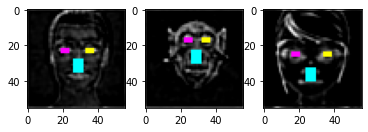

In [10]:
# show RBF on face
plt.figure()
for i in range(3):
    img = preds[i, ..., 0]
    img_norm = img / np.amax(img)
    img_norm = np.repeat(np.expand_dims(img_norm, axis=2), 3, axis=2)
    print("shape img_norm", np.shape(img_norm))

    img_norm[rbf_templates[i][0, 0, 0]:rbf_templates[i][0, 0, 1], rbf_templates[i][0, 1, 0]:rbf_templates[i][0, 1, 1]] = [1, 0, 1]
    img_norm[rbf_templates[i][1, 0, 0]:rbf_templates[i][1, 0, 1], rbf_templates[i][1, 1, 0]:rbf_templates[i][1, 1, 1]] = [1, 1, 0]
    img_norm[rbf_templates[i][2, 0, 0]:rbf_templates[i][2, 0, 1], rbf_templates[i][2, 1, 0]:rbf_templates[i][2, 1, 1]] = [0, 1, 1]

    plt.subplot(1, 3, i + 1)
    plt.imshow(img_norm, cmap='viridis')

# fit template

In [11]:
# fit templates
templates = []
for i in range(3):
    # template = patterns.fit(mask_template)
    _preds = np.expand_dims(preds[i], axis=0)
    template_preds = np.repeat(np.expand_dims(_preds, axis=0), len(rbf_templates[i]), axis=0)
    print("shape template preds", np.shape(template_preds))
    template = patterns[i].fit(template_preds)
    template[template < 0.25] = 0
    print("shape template", np.shape(template), np.amin(template), np.amax(template))
    templates.append(template)
print("shape templates", np.shape(templates))
templates = np.concatenate((templates[0], templates[1], templates[2]), axis=3)
print("shape templates", np.shape(templates))

shape template preds (3, 1, 56, 56, 68)
[PATTERN] Fit pattern
shape template (1, 56, 56, 3) 0.0 1.0
shape template preds (3, 1, 56, 56, 68)
[PATTERN] Fit pattern
shape template (1, 56, 56, 3) 0.0 1.0
shape template preds (3, 1, 56, 56, 68)
[PATTERN] Fit pattern
shape template (1, 56, 56, 3) 0.0 1.0
shape templates (3, 1, 56, 56, 3)
shape templates (1, 56, 56, 9)


0 min max 0.0 1.0
1 min max 0.0 1.0
2 min max 0.0 1.0
3 min max 0.0 1.0
4 min max 0.0 1.0
5 min max 0.0 1.0
6 min max 0.0 1.0
7 min max 0.0 1.0
8 min max 0.0 1.0


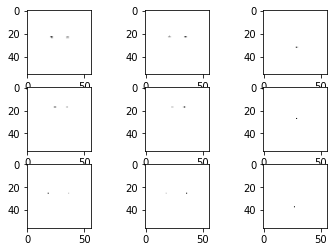

In [12]:
# plot template
plt.figure()
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, i * 3 + j + 1)
        _template = templates[0, ..., i * 3 + j]
        print(i * 3 + j, "min max", np.amin(_template), np.amax(_template))
        plt.imshow(_template, cmap='Greys')

# get patches

In [13]:
# split in patches
def pred_to_patch(pred, patch_size=8):
    pred = np.expand_dims(pred, axis=[0, 3])
    patches = tf.image.extract_patches(
        images=pred,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patches = patches.numpy()
    return patches

In [14]:
# test function pred_to_patch
patches = pred_to_patch(templates[0, ..., 0])
print("shape patches", np.shape(patches))

shape patches (1, 7, 7, 64)


In [15]:
def get_patches_centers(patches, patch_size=8, verbose=False):
    # compute center of activity for each patch
    centers = []
    max_patch = []
    for i in range(np.shape(patches)[1]):
        for j in range(np.shape(patches)[2]):
            # control if patches is not all zeros
            f_patch = patches[0, i, j]
            if np.sum(f_patch) > 0:
                CoA = compute_center_of_activity(np.reshape(f_patch, [patch_size, patch_size]), verbose=verbose)
                # compensate with patch positions
                centers.append([CoA[0] + j*patch_size, CoA[1] + i*patch_size])

                # keep maximum activity of the patch
                max_patch.append(np.amax(f_patch))

    return centers, max_patch

In [16]:
# test function get_patches_centers
centers, max_patch = get_patches_centers(patches)
print("shape centers", np.shape(centers))
print("max_patch", max_patch)

shape centers (4, 2)
max_patch [1.0, 0.5410039152582466, 0.31266802716988085, 0.2887253002445825]


# Get activity from patches

In [17]:
def get_activity_from_patterns(preds, patterns, rbf_templates, threshold_val=0.25, do_plot=False):
    templates = []
    for p, pattern in enumerate(patterns):
        _preds = np.expand_dims(preds, axis=0)
        _preds = np.repeat(np.expand_dims(_preds, axis=0), len(rbf_templates[p]), axis=0)
        template = pattern.transform(_preds)
        print("max template pattern {}: {}".format(p, np.max(template, axis=(0, 1, 2))))
        template[template < threshold_val] = 0
        templates.append(template)

        if do_plot:
            plt.figure()
            plt.subplot(1, 3, 1)
            plt.imshow(template[0, ..., 0], cmap='Greys')
            plt.subplot(1, 3, 2)
            plt.imshow(template[0, ..., 1], cmap='Greys')
            plt.subplot(1, 3, 3)
            plt.imshow(template[0, ..., 2], cmap='Greys')


    # concatenate all templates
    _templates = np.array(templates[0])
    for i in range(1, len(patterns)):
        _templates = np.concatenate((_templates, templates[i]), axis=3)

    # get pos for each type
    pos_dict = {}
    n_entry = 0
    for i in range(np.shape(_templates)[-1]):
        patches = pred_to_patch(_templates[0, ..., i])
        positions, max_values = get_patches_centers(patches)

        for pos, max_val in zip(positions, max_values):
            pos_dict[n_entry] = {'type': i, 'pos': pos, 'max': max_val}
            n_entry += 1

    return pos_dict

max template pattern 0: [1. 1. 1.]
max template pattern 1: [0.154 0.201 0.03 ]
max template pattern 2: [0.    0.    0.002]
max template pattern 0: [0.209 0.201 0.065]
max template pattern 1: [1. 1. 1.]
max template pattern 2: [0.    0.    0.001]
max template pattern 0: [0.148 0.111 0.102]
max template pattern 1: [0.107 0.088 0.003]
max template pattern 2: [1. 1. 1.]


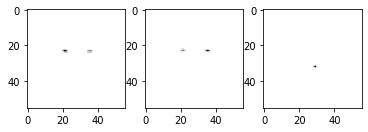

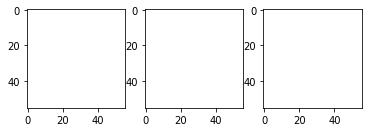

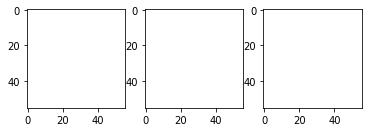

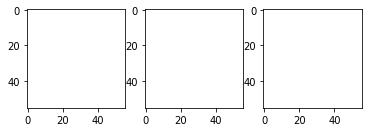

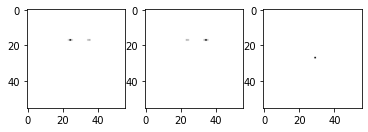

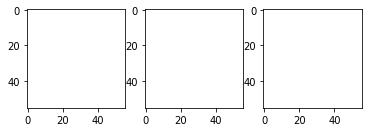

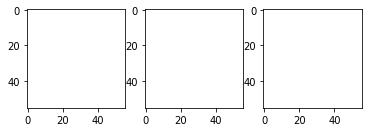

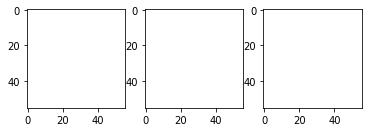

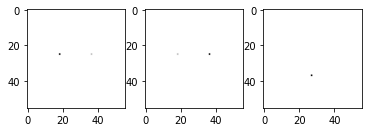

In [18]:
activities_dict = []
for i in range(3):
    activity_dict = get_activity_from_patterns(preds[i], patterns, rbf_templates, do_plot=True)
    activities_dict.append(activity_dict)

In [19]:
def get_pos_from_dict(dict, ratio=None):
    pos = []
    for i in dict:
        pos.append(dict[i]["pos"])

    pos = np.array(pos)

    if ratio is not None:
        pos = np.round(pos * ratio).astype(int)

    return pos

In [20]:
def get_lmk_colors(dict):
    colors = []
    for i in dict:
        print("entry dict:", dict[i])
        if dict[i]["type"] in [0, 3, 6]:
            colors.append([1, 0, 0])
        elif dict[i]["type"] in [1, 4, 7]:
            colors.append([1, 1, 0])
        elif dict[i]["type"] in [2, 5, 8]:
            colors.append([0, 1, 1])
        else:
            print("[get_lmk_colors] type {} not found!".format(dict[i]["type"]))
            colors.append([1, 1, 1])

    return colors

In [21]:
# display activities
for i in range(3):
    activity_dict = activities_dict[i]
    for a in activity_dict:
        print(activity_dict[a])
    print()

{'type': 0, 'pos': [20.998667068615653, 22.999979554400607], 'max': 1.0}
{'type': 0, 'pos': [35.05277882762909, 22.999967029537842], 'max': 0.5410039152582466}
{'type': 0, 'pos': [21.485743587610955, 24.0], 'max': 0.31266802716988085}
{'type': 0, 'pos': [34.99434313282795, 24.0], 'max': 0.2887253002445825}
{'type': 1, 'pos': [20.952313213242416, 22.84000873533725], 'max': 0.5371863070262026}
{'type': 1, 'pos': [34.98716208914087, 22.999979417334806], 'max': 1.0}
{'type': 2, 'pos': [28.97691162181664, 32.0], 'max': 1.0}

{'type': 3, 'pos': [22.99984463818652, 16.999977805455217], 'max': 0.2883527469270722}
{'type': 3, 'pos': [24.231869043970843, 16.999995083993344], 'max': 1.0}
{'type': 3, 'pos': [34.54414684331473, 16.99999264492359], 'max': 0.47350071540824223}
{'type': 4, 'pos': [22.999898548128208, 16.999985506875458], 'max': 0.4415822982474982}
{'type': 4, 'pos': [24.0, 16.99998368771499], 'max': 0.39233593566293384}
{'type': 4, 'pos': [33.98662305756311, 16.999996353923336], 'max'

In [22]:
def max_pool_activity(activity_dict, dist_threshold=3, sorting='max', verbose=False):
    filt_dictionary = {}
    discarded_primer_idx = []

    for p_t in range(len(activity_dict)):
        for p_a in range(p_t + 1, len(activity_dict)):  # only upward diagonal
            # get primers
            p_target = activity_dict[p_t]
            p_agent = activity_dict[p_a]

            # retrieve positions
            pos_target = np.array(p_target["pos"])
            pos_agent = np.array(p_agent["pos"])
            distance = np.linalg.norm(pos_target - pos_agent)

            if verbose:
                print("distance", distance)

            # sort if distance is smaller than the threshold
            if distance < dist_threshold:
                # todo add possibility to sort by clustering the mean
                if sorting == 'max':
                    if p_target["max"] > p_agent["max"]:
                        discarded_primer_idx.append(p_a)
                    else:
                        discarded_primer_idx.append(p_t)

    if verbose:
        print("discarded primers")
        print(discarded_primer_idx)

    # append all non discarded primers
    n_primer = 0
    for p in activity_dict:
        if p not in discarded_primer_idx:
            primer = activity_dict[p]
            filt_dictionary[n_primer] = {"type": primer["type"], "pos": primer["pos"], "max": primer["max"]}
            n_primer += 1

    return filt_dictionary

In [23]:
activities_dict_max_pooled = []
for i in range(3):
    activity_dict = max_pool_activity(activities_dict[i])
    activities_dict_max_pooled.append(activity_dict)

In [24]:
# display activities
for i in range(3):
    activity_dict = activities_dict_max_pooled[i]
    for a in activity_dict:
        print(activity_dict[a])
    print()

{'type': 0, 'pos': [20.998667068615653, 22.999979554400607], 'max': 1.0}
{'type': 1, 'pos': [34.98716208914087, 22.999979417334806], 'max': 1.0}
{'type': 2, 'pos': [28.97691162181664, 32.0], 'max': 1.0}

{'type': 3, 'pos': [24.231869043970843, 16.999995083993344], 'max': 1.0}
{'type': 4, 'pos': [33.98662305756311, 16.999996353923336], 'max': 1.0}
{'type': 5, 'pos': [28.9999680002048, 26.999980800122877], 'max': 1.0}

{'type': 6, 'pos': [17.999987200081918, 24.99999360004096], 'max': 1.0}
{'type': 7, 'pos': [35.999974400163836, 24.99999360004096], 'max': 1.0}
{'type': 8, 'pos': [26.999980800122877, 36.999968000204795], 'max': 1.0}



entry dict: {'type': 0, 'pos': [20.998667068615653, 22.999979554400607], 'max': 1.0}
entry dict: {'type': 1, 'pos': [34.98716208914087, 22.999979417334806], 'max': 1.0}
entry dict: {'type': 2, 'pos': [28.97691162181664, 32.0], 'max': 1.0}
entry dict: {'type': 3, 'pos': [24.231869043970843, 16.999995083993344], 'max': 1.0}
entry dict: {'type': 4, 'pos': [33.98662305756311, 16.999996353923336], 'max': 1.0}
entry dict: {'type': 5, 'pos': [28.9999680002048, 26.999980800122877], 'max': 1.0}
entry dict: {'type': 6, 'pos': [17.999987200081918, 24.99999360004096], 'max': 1.0}
entry dict: {'type': 7, 'pos': [35.999974400163836, 24.99999360004096], 'max': 1.0}
entry dict: {'type': 8, 'pos': [26.999980800122877, 36.999968000204795], 'max': 1.0}


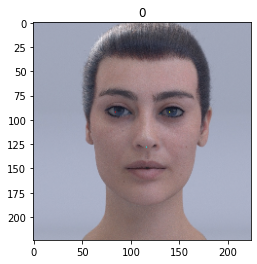

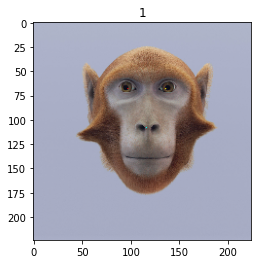

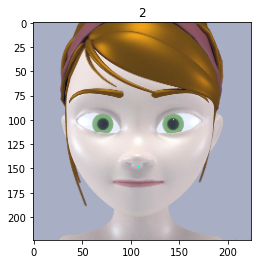

In [25]:
# print landmarks
for i in range(3):
    pos = get_pos_from_dict(activities_dict_max_pooled[i], ratio=224/56)
    lmk_color = get_lmk_colors(activities_dict_max_pooled[i])
    plot_images([[data[0][i]]], lmk_pos=pos, lmk_colors=lmk_color, title=str(i))

# Get Type from activity

In [26]:
"""
max pool the types of the dictionary to get the face type
"""
def get_type(activity_dict, verbose=False):
    types = [0, 0, 0]  # hum_type, monk_type, cart_type

    for i in activity_dict:
        if verbose:
            print(activity_dict[i])
        dict = activity_dict[i]

        # count types
        if dict['type'] in [0, 1, 2]:
            types[0] += 1
        elif dict['type'] in [3, 4, 5]:
            types[1] += 1
        elif dict['type'] in [6, 7, 8]:
            types[2] += 1

    if verbose:
        print("types:", types)

    bfs_type = np.argmax(types)

    return bfs_type

In [27]:
types = ["human", "monkey", "cartoon"]
bfs_types = []
for i in range(3):
    bfs_type = get_type(activities_dict_max_pooled[i])
    bfs_types.append(bfs_type)
    print("type:", types[bfs_type])

type: human
type: monkey
type: cartoon


# Apply "graph" (infer face structure from a reference structure)

In [28]:
def control_face_struct(activities_dict, ref_struct):
    correct_face_struct = False
    correct_types = [ref_struct[i]["type"] for i in ref_struct]

    counter = np.zeros(np.max(correct_types) + 1)
    for i in activities_dict:
        idx = activities_dict[i]["type"]
        if idx in correct_types:
            counter[idx] += 1
        else:
            break

    # control that the dictionary has exactly one entry per node
    if np.sum(counter) == len(correct_types) and np.max(counter) == 1:
        correct_face_struct = True

    return correct_face_struct


In [29]:
def find_higest_actitivity_node(activities_dict):
    highest_activity = 0
    highest_idx = 0

    for i in activities_dict:
        activity = activities_dict[i]["max"]

        if activity > highest_activity:
            highest_idx = i
            highest_activity = activity

    return activities_dict[highest_idx]

In [30]:
def remove_activity_from_type(activities_dict, ref_type_dict):
    filtered_dict = {}

    for i in activities_dict:
        if activities_dict[i]["type"] != ref_type_dict["type"]:
            filtered_dict[i] = activities_dict[i]

    return filtered_dict

In [31]:
def infer_left_eye(face_pos1, face_pos2, ref_pos1, ref_pos2, prior_pos):
    print("infer left eye")
    # compute diff between nose of ref and face (need only vertical axis)
    print("ref_pos2[0] - face_pos2[0]: {:.2f} - {:.2f}".format(ref_pos2[0], face_pos2[0]))
    diff_pos2X = ref_pos2[0] - face_pos2[0]
    print("diff nose", diff_pos2X)

    # compute diff from left eye to ref according to diff of pos2
    print("ref_pos1[0] - face_pos1[0]: {:.2f} - {:.2f}".format(ref_pos1[0], face_pos1[0]))
    diff_pos1X = ref_pos1[0] - face_pos1[0]
    print("diff eye", diff_pos1X)

    # infer third positions
    print("diff to apply: diff_pos1X - diff_pos2X: {}".format(diff_pos1X - diff_pos2X))
    print("result prior_pos['pos''][0]: {} -> {}".format(prior_pos["pos"][0], prior_pos["pos"][0] + diff_pos1X - diff_pos2X))
    return [prior_pos["pos"][0] + diff_pos1X - diff_pos2X, face_pos1[1]]

In [32]:
def infer_right_eye(face_pos1, face_pos2, ref_pos1, ref_pos2, prior_pos):
    print("infer right eye")
    # compute diff between nose of ref and face (need only vertical axis)
    print("ref_pos2[0] - face_pos2[0]: {:.2f} - {:.2f}".format(ref_pos2[0], face_pos2[0]))
    diff_pos2X = ref_pos2[0] - face_pos2[0]
    print("diff nose", diff_pos2X)

    # compute diff from left eye to ref according to diff of pos2
    print("ref_pos1[0] - face_pos1[0]: {:.2f} - {:.2f}".format(ref_pos1[0], face_pos1[0]))
    diff_pos1X = ref_pos1[0] - face_pos1[0]
    print("diff eye", diff_pos1X)

    # infer third positions
    print("diff to apply: diff_pos1X - diff_pos2X: {}".format(diff_pos1X - diff_pos2X))
    print("result prior_pos['pos''][0]: {} -> {}".format(prior_pos["pos"][0], prior_pos["pos"][0] + diff_pos1X - diff_pos2X))
    return [prior_pos["pos"][0] + diff_pos1X - diff_pos2X, face_pos1[1]]

In [33]:
def infer_nose(face_pos1, face_pos2, ref_pos1, ref_pos2, prior_pos):
    print("TODO infer nose!, so far simply return the prior since the dataset is super simple...")
    return prior_pos["pos"]

In [34]:
def fit_lmk_to_ref(face_struct, ref_struct, verbose=False):
    """
    Simply try to infer the third landmarks from the two first. The "graph" is a simple triangle for now

    :param face_struct:
    :param ref_struct:
    :return:
    """
    # retrieve positions of current face
    face_pos = [face_struct[0]["pos"], face_struct[1]["pos"]]

    # retrieve positions of reference face for same landmarks
    ref_pos = []
    idx_found = np.zeros(len(ref_struct))
    for i in face_struct:
        lmk_type = face_struct[i]["type"]
        for j in ref_struct:
            if ref_struct[j]["type"] == lmk_type:
               ref_pos.append(ref_struct[j]["pos"])
               idx_found[j] = 1
    idx_to_infer = np.arange(len(ref_struct))
    idx_to_infer = idx_to_infer[idx_found == 0]
    if len(idx_to_infer) > 1:
        print("more than one landmark to infer!")
    idx_to_infer = idx_to_infer[0]
    prior = ref_struct[idx_to_infer]

    if face_struct[0]["type"] in [0, 3, 6] and face_struct[1]["type"] in [2, 5, 8]:
        # infer left eye
        lmk = infer_left_eye(face_pos[0], face_pos[1], ref_pos[0], ref_pos[1], prior)
    elif face_struct[1]["type"] in [0, 3, 6] and face_struct[0]["type"] in [2, 5, 8]:
        # infer left eye inverse
        lmk = infer_left_eye(face_pos[1], face_pos[0], ref_pos[1], ref_pos[0], prior)
    elif face_struct[0]["type"] in [0, 3, 6] and face_struct[1]["type"] in [1, 4, 7]:
        # infer nose
        lmk = infer_nose(face_pos[0], face_pos[1], ref_pos[0], ref_pos[1], prior)
    elif face_struct[1]["type"] in [0, 3, 6] and face_struct[0]["type"] in [1, 4, 7]:
        # infer nose inverse
        lmk = infer_nose(face_pos[1], face_pos[0], ref_pos[1], ref_pos[0], prior)
    elif face_struct[0]["type"] in [1, 4, 7] and face_struct[1]["type"] in [2, 5, 8]:
        # infer right eye
        lmk = infer_right_eye(face_pos[0], face_pos[1], ref_pos[0], ref_pos[1], prior)
    elif face_struct[1]["type"] in [1, 4, 7] and face_struct[0]["type"] in [2, 5, 8]:
        # infer right eye inverse
        lmk = infer_right_eye(face_pos[1], face_pos[0], ref_pos[1], ref_pos[0], prior)
    else:
        raise NotImplementedError("inferring landmarks from {} and {} is not yet implemented!".format(face_struct[0]["type"], face_struct[1]["type"]))

    if verbose:
        print("idx_to_infer", idx_to_infer)
        print("prior:", prior)
        print("lmk_pos", lmk)

    return {"type": prior["type"], "pos": lmk, "max": 1.0}

In [35]:
def get_closest_lmk(activities_dict, ref_dict):
    print("get_closest_lmk")
    closest_lmk = {"type": 0, "pos": [0, 0], "max": 0.0}
    min_dist = 1e10

    print("ref_dict['pos']", ref_dict["pos"])
    for i in activities_dict:
        print("activities_dict[i]['pos']", activities_dict[i]["pos"])
        dist = np.linalg.norm(np.array(activities_dict[i]["pos"]) - np.array(ref_dict["pos"]))
        print("dist between lmk:", dist)
        if dist < min_dist:
            closest_lmk = activities_dict[i]
            min_dist = dist

    return closest_lmk

In [36]:
def get_face_structure(activities_dict, ref_struct, verbose=False):
    """
    infer or clean landmarks to return a perfect face structure for one faace
    :return:
    """

    face_struc_dict = {}
    # control if the activity dict has one node of each type
    is_correct_struct = control_face_struct(activities_dict, ref_struct)

    if verbose:
        face_struct = []
        for i in activities_dict:
            face_struct.append(activities_dict[i]["type"])
        print("struct:", face_struct)
        print("is_correct_struct:", is_correct_struct)

    # if missing or having too many nodes
    if not is_correct_struct:
        # start with the highest activity and discard others form this type
        highest_activity_node = find_higest_actitivity_node(activities_dict)
        filtered_activity = remove_activity_from_type(activities_dict, highest_activity_node)
        face_struc_dict[0] = highest_activity_node

        # get the position of the highest activity from the second type
        highest_activity_2_node = find_higest_actitivity_node(filtered_activity)
        filtered_activity = remove_activity_from_type(filtered_activity, highest_activity_2_node)
        face_struc_dict[1] = highest_activity_2_node

        # infer third landmarks
        infer_struct_dict = fit_lmk_to_ref(face_struc_dict, ref_struct, verbose=verbose)
        print("infer_struct_dict", infer_struct_dict)

        # check if we need to infer or retrieve the closest activity
        if len(filtered_activity) == 0:
            # simply use the inferred third positions from first two points
            face_struc_dict[2] = infer_struct_dict
        else:
            # retrieve the closest landmark from the inference
            closest_lmk = get_closest_lmk(filtered_activity, infer_struct_dict)
            face_struc_dict[2] = closest_lmk

        if verbose:
            print("activities_dict")
            print(activities_dict)
            print("ref_struct")
            print(ref_struct)
            print("highest_activity_node", highest_activity_node)
            print("filtered_activity", filtered_activity)
            print("highest_activity_2_node", highest_activity_2_node)
            print("filtered_activity", filtered_activity)
            print("face_struc_dict", face_struc_dict)
            print("infer_struct_dict", infer_struct_dict)
    else:
        face_struc_dict = activities_dict

    return face_struc_dict

In [37]:
ref_struct = activities_dict_max_pooled
face_structures = []
for i in range(3):
    face_dict = get_face_structure(activities_dict_max_pooled[i], ref_struct[bfs_types[i]])
    face_structures.append(face_dict)
    print("face_dict:", face_dict)
    print()

face_dict: {0: {'type': 0, 'pos': [20.998667068615653, 22.999979554400607], 'max': 1.0}, 1: {'type': 1, 'pos': [34.98716208914087, 22.999979417334806], 'max': 1.0}, 2: {'type': 2, 'pos': [28.97691162181664, 32.0], 'max': 1.0}}

face_dict: {0: {'type': 3, 'pos': [24.231869043970843, 16.999995083993344], 'max': 1.0}, 1: {'type': 4, 'pos': [33.98662305756311, 16.999996353923336], 'max': 1.0}, 2: {'type': 5, 'pos': [28.9999680002048, 26.999980800122877], 'max': 1.0}}

face_dict: {0: {'type': 6, 'pos': [17.999987200081918, 24.99999360004096], 'max': 1.0}, 1: {'type': 7, 'pos': [35.999974400163836, 24.99999360004096], 'max': 1.0}, 2: {'type': 8, 'pos': [26.999980800122877, 36.999968000204795], 'max': 1.0}}



# get face attributes (positions, types, scales)

In [38]:
def get_face_pos(activity_dict, verbose=False):
    positions = []

    for i in activity_dict:
        dict = activity_dict[i]

        # get positions of types
        if dict['type'] in [0, 3, 6]:
            right_eye_pos = dict['pos']
        elif dict['type'] in [1, 4, 7]:
            left_eye_pos = dict['pos']
        elif dict['type'] in [2, 5, 8]:
            nose_pos = dict['pos']

        positions.append(dict['pos'])

        if verbose:
            print("positions")
            print(positions)

    mean_pos = np.mean(positions, axis=0)
    width = left_eye_pos[0] - right_eye_pos[0]
    height = nose_pos[1] - np.amin([left_eye_pos[1], right_eye_pos[1]])

    return mean_pos, [width, height]

In [39]:
positions = []
sizes = []
for i in range(3):
    pos, size = get_face_pos(face_structures[i])
    positions.append(pos)
    sizes.append(size)
    print("pos:", pos)
    print("size:", size)
    print()

pos: [28.321 26.   ]
size: [13.988495020525214, 9.000020582665194]

pos: [29.073 20.333]
size: [9.754754013592265, 9.999985716129533]

pos: [27. 29.]
size: [17.999987200081918, 11.999974400163836]



# predict on test set

In [40]:
def predict_face_attributes(preds, patterns, rbf_templates, ref_struct, verbose=False):
    activity_dict = get_activity_from_patterns(preds, patterns, rbf_templates)
    activities_dict_max_pooled = max_pool_activity(activity_dict)

    bfs_type = get_type(activity_dict)
    face_dict = get_face_structure(activities_dict_max_pooled, ref_struct[bfs_type])
    pos, size = get_face_pos(face_dict)

    if verbose:
        print("pos:", pos)
        print("size:", size)
        print()

    return [bfs_type, pos, size]

In [41]:
for i in range(3):
    attributes = predict_face_attributes(preds[i], patterns, rbf_templates, ref_struct)
    print("type:", attributes[0])
    print("pos:", attributes[1])
    print("size:", attributes[2])
    print()

max template pattern 0: [1. 1. 1.]
max template pattern 1: [0.154 0.201 0.03 ]
max template pattern 2: [0.    0.    0.002]
type: 0
pos: [28.321 26.   ]
size: [13.988495020525214, 9.000020582665194]

max template pattern 0: [0.209 0.201 0.065]
max template pattern 1: [1. 1. 1.]
max template pattern 2: [0.    0.    0.001]
type: 1
pos: [29.073 20.333]
size: [9.754754013592265, 9.999985716129533]

max template pattern 0: [0.148 0.111 0.102]
max template pattern 1: [0.107 0.088 0.003]
max template pattern 2: [1. 1. 1.]
type: 2
pos: [27. 29.]
size: [17.999987200081918, 11.999974400163836]



In [42]:
# get all reference identities
test_data = load_data(config, train=False)
print("shape test data", np.shape(test_data[0]))

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 12/12 [00:00<00:00, 167.05it/s]

shape test data (12, 224, 224, 3)


In [43]:
# predict v4 output
test_preds = predict_v4(test_data)

1/1 [==============================] - 0s 31ms/step
[predict_v4] shape prediction (12, 56, 56, 256)
[predict_v4] shape eyebrow semantic feature selection (12, 56, 56, 7)
[predict_v4] shape lips semantic feature selection (12, 56, 56, 61)
[predict_v4] shape preds (12, 56, 56, 68)


In [44]:
id_params = []
for p, pred in enumerate(test_preds):
    print(p)
    id_param = predict_face_attributes(pred, patterns, rbf_templates, ref_struct)
    id_params.append(id_param)

0
max template pattern 0: [0.787 0.728 0.461]
max template pattern 1: [0.219 0.258 0.019]
max template pattern 2: [0.    0.    0.002]
1
max template pattern 0: [0.844 0.942 0.772]
max template pattern 1: [0.185 0.216 0.025]
max template pattern 2: [0.    0.    0.002]
2
max template pattern 0: [0.853 0.913 0.817]
max template pattern 1: [0.185 0.197 0.019]
max template pattern 2: [0.    0.    0.002]
3
max template pattern 0: [0.891 0.741 0.609]
max template pattern 1: [0.174 0.209 0.013]
max template pattern 2: [0.    0.    0.002]
4
max template pattern 0: [0.213 0.169 0.058]
max template pattern 1: [0.749 0.654 0.435]
max template pattern 2: [0.    0.    0.001]
5
max template pattern 0: [0.198 0.19  0.073]
max template pattern 1: [0.685 0.767 0.749]
max template pattern 2: [0.    0.    0.001]
6
max template pattern 0: [0.202 0.195 0.07 ]
max template pattern 1: [0.767 0.838 0.789]
max template pattern 2: [0.    0.    0.002]
7
max template pattern 0: [0.176 0.174 0.068]
max template pat

In [45]:
for id_param in id_params:
    print(id_param)

[0, array([27.897, 26.   ]), [10.87152153142248, 9.000029901533658]]
[0, array([28.084, 26.   ]), [12.458403923938242, 9.000022413308695]]
[0, array([28.523, 26.   ]), [15.230274212284655, 9.000018758920387]]
[0, array([28.694, 26.   ]), [16.51777003251572, 9.000019789793011]]
[1, array([28.771, 20.333]), [7.87679104374336, 9.999962049969263]]
[1, array([28.947, 20.333]), [8.940589820612004, 9.999979511469803]]
[1, array([29.186, 20.333]), [10.558616369369823, 9.999984017309455]]
[1, array([29.055, 20.333]), [12.165851328573538, 9.999970900624575]]
[2, array([27., 29.]), [14.000002718510611, 11.99994676437295]]
[2, array([27., 29.]), [16.000005742061138, 11.999971083488887]]
[2, array([27.011, 29.   ]), [19.999967948174888, 11.999986326646582]]
[2, array([27.104, 29.   ]), [21.99991028777027, 11.999990082058833]]


# get identity

In [46]:
# compute ratio, since this is the identity parameter!
for id_param in id_params:
    ref_size = sizes[id_param[0]]
    ratio = id_param[2][0] / ref_size[0]

    print("ratio:", ratio)


ratio: 0.7771759231762086
ratio: 0.8906178903204469
ratio: 1.0887714646884734
ratio: 1.1808110885609437
ratio: 0.8074822832813464
ratio: 0.9165366761841657
ratio: 1.082407240065455
ratio: 1.2471715136662238
ratio: 0.7777784818895258
ratio: 0.8888898399876819
ratio: 1.111110120571856
ratio: 1.2222181073367735


## Test templates on all facial expressions

In [47]:
config["val_expression"] = ["full"]
test_fer_data = load_data(config, train=False)
print("[LOAD] test_fer_data loaded", np.shape(test_fer_data[0]))

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 84/84 [00:00<00:00, 177.13it/s]

[LOAD] test_fer_data loaded (84, 224, 224, 3)


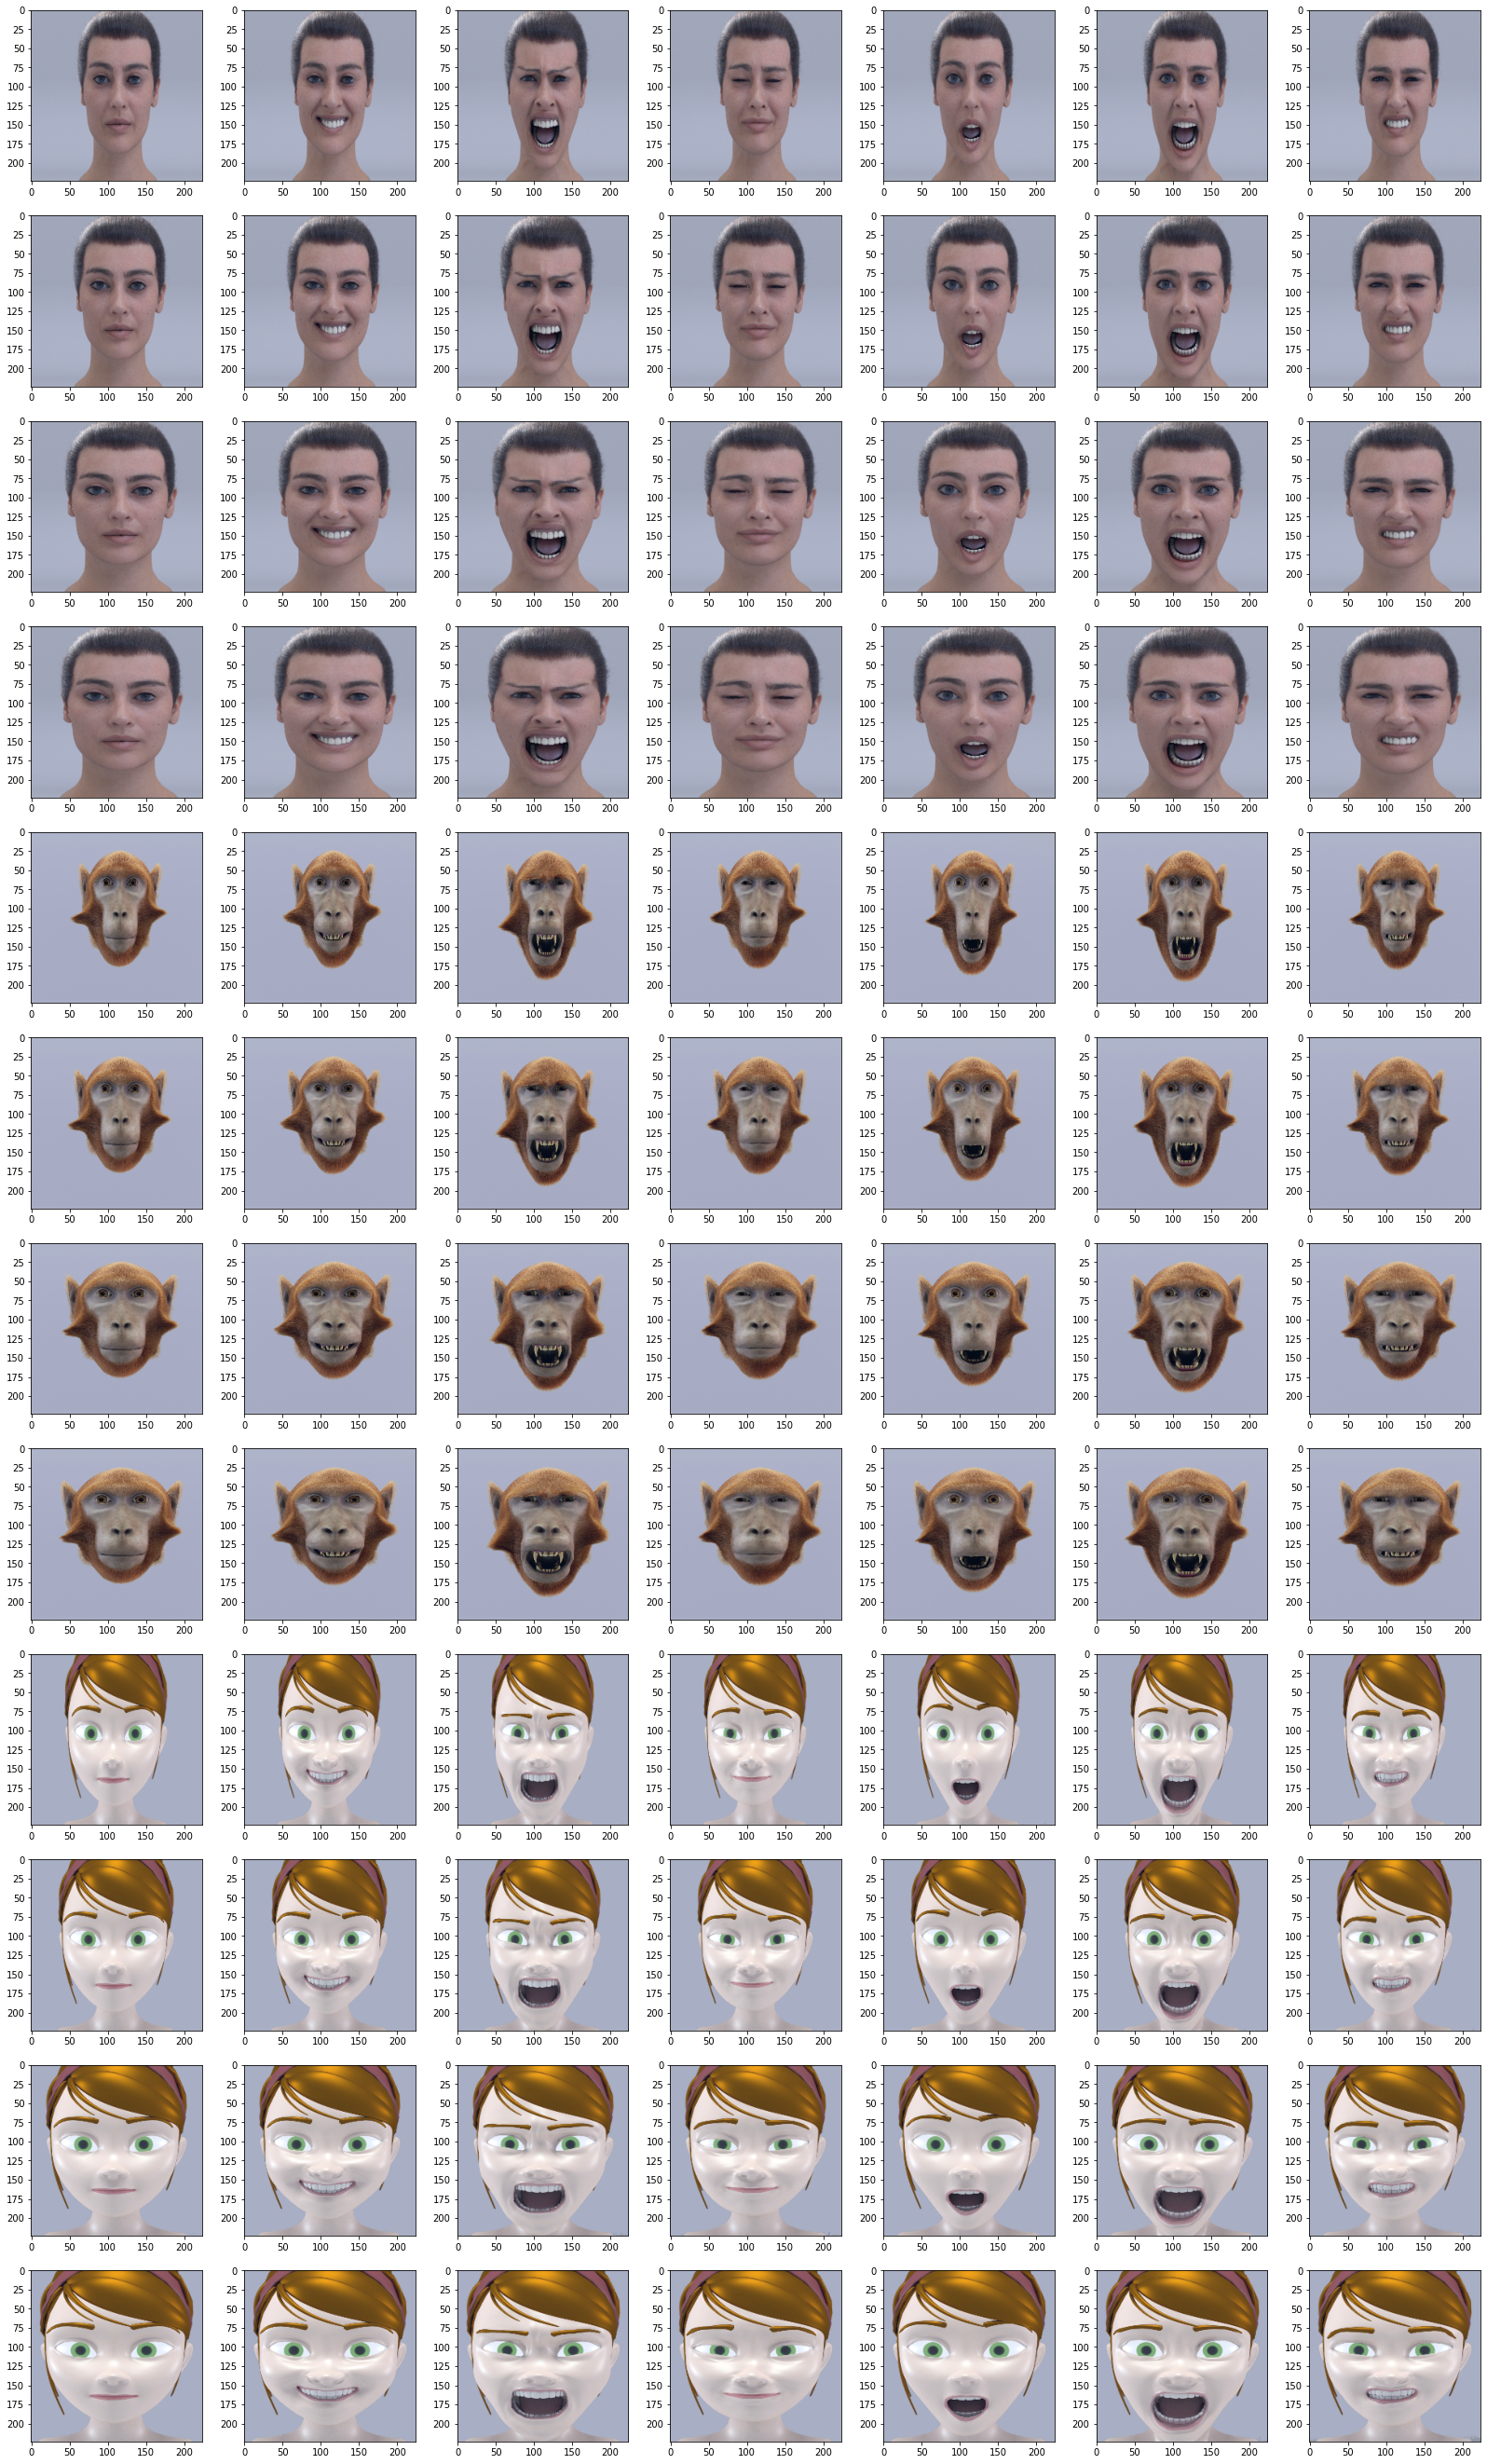

In [48]:
plot_images(test_fer_data)

In [49]:
# predict v4 output
test_fr_preds = predict_v4(test_fer_data)
print("shape test_fr_preds", np.shape(test_fr_preds))

3/3 [==============================] - 0s 177ms/step
[predict_v4] shape prediction (84, 56, 56, 256)
[predict_v4] shape eyebrow semantic feature selection (84, 56, 56, 7)
[predict_v4] shape lips semantic feature selection (84, 56, 56, 61)
[predict_v4] shape preds (84, 56, 56, 68)
shape test_fr_preds (84, 56, 56, 68)


In [50]:
# get_activity_from_patterns(test_fr_preds[3], patterns, rbf_templates, threshold_val=0.20, do_plot=True)

In [51]:
def check_unpooled_lmk(data, preds, verbose=False, do_plot=False):
    activities_dict = []
    #for i in range(np.shape(test_fer_preds)[0]):
    for i in range(len(preds)):
        if verbose:
            print("pred:", i)

        activity_dict = get_activity_from_patterns(preds[i], patterns, rbf_templates, threshold_val=0.2)
        activities_dict.append(activity_dict)

        if verbose:
            for a in activity_dict:
                print("{}:".format(a), activity_dict[a])
            print()

        if do_plot:
            # plot lmk on image
            pos = get_pos_from_dict(activity_dict, ratio=224/56)
            lmk_color = get_lmk_colors(activity_dict)
            plot_images([[data[0][i]]], lmk_pos=pos, lmk_colors=lmk_color, title=str(i))

    return activities_dict

In [52]:
# idx = np.arange(0, 7)
# idx = np.arange(7, 14)
# idx = np.arange(14, 21)
# idx = np.arange(21, 28)
idx = np.arange(28, 35)
test_fer_data_print = [test_fer_data[0][idx], test_fer_data[1][idx]]
fr_lmk = check_unpooled_lmk(test_fer_data_print, test_fr_preds[idx], verbose=True, do_plot=False)

pred: 0
max template pattern 0: [0.213 0.169 0.058]
max template pattern 1: [0.749 0.654 0.435]
max template pattern 2: [0.    0.    0.001]
0: {'type': 0, 'pos': [32.99996990976729, 16.99996990976729], 'max': 0.2126872026591118}
1: {'type': 3, 'pos': [24.767112602282428, 17.172138498728476], 'max': 0.7494014060635265}
2: {'type': 3, 'pos': [33.371465925156194, 16.99998939144466], 'max': 0.3791734276225809}
3: {'type': 4, 'pos': [24.463717964879205, 16.999992010495646], 'max': 0.4295828302072977}
4: {'type': 4, 'pos': [32.66408891518972, 17.16960646718329], 'max': 0.6537983939242501}
5: {'type': 5, 'pos': [28.99992652046887, 26.999955912281322], 'max': 0.43548902992110083}

pred: 1
max template pattern 0: [0.22  0.178 0.03 ]
max template pattern 1: [0.702 0.667 0.302]
max template pattern 2: [0.    0.    0.001]
0: {'type': 0, 'pos': [32.99997089928453, 16.99997089928453], 'max': 0.2199194642453764}
1: {'type': 3, 'pos': [24.909926160439102, 16.999994775997855], 'max': 0.7023632333318959

In [53]:
def check_pooled_lmk(data, activities_dict, verbose=False, do_plot=False):
    max_pooled_activities_dict = []

    for i in range(len(activities_dict)):
        activity_dict = max_pool_activity(activities_dict[i])
        max_pooled_activities_dict.append(activity_dict)

        if verbose:
            print("pred:", i)
            for a in activity_dict:
                print(activity_dict[a])
            print()

        if do_plot:
            # plot lmk on image
            pos = get_pos_from_dict(activity_dict, ratio=224/56)
            lmk_color = get_lmk_colors(activity_dict)
            plot_images([[data[0][i]]], lmk_pos=pos, lmk_colors=lmk_color, title=str(i))

    return max_pooled_activities_dict

In [54]:
fr_lmk_pooled = check_pooled_lmk(test_fer_data_print, fr_lmk, verbose=True, do_plot=False)

pred: 0
{'type': 3, 'pos': [24.767112602282428, 17.172138498728476], 'max': 0.7494014060635265}
{'type': 4, 'pos': [32.66408891518972, 17.16960646718329], 'max': 0.6537983939242501}
{'type': 5, 'pos': [28.99992652046887, 26.999955912281322], 'max': 0.43548902992110083}

pred: 1
{'type': 3, 'pos': [24.909926160439102, 16.999994775997855], 'max': 0.7023632333318959}
{'type': 4, 'pos': [32.60394271406113, 16.999994204889628], 'max': 0.6669818384008224}
{'type': 5, 'pos': [28.999894008896824, 26.999936405338094], 'max': 0.30190573262708786}

pred: 2
{'type': 3, 'pos': [24.99997713641505, 16.99997713641505], 'max': 0.27991470661992646}
{'type': 3, 'pos': [26.999915103142136, 26.999915103142136], 'max': 0.2261503799210256}
{'type': 4, 'pos': [32.56090866956677, 16.999988072226053], 'max': 0.30096273630011366}

pred: 3
{'type': 3, 'pos': [24.999980860936947, 16.999980860936947], 'max': 0.33438823482828933}
{'type': 4, 'pos': [32.58844771686281, 16.99999070108376], 'max': 0.40500046361115255}


In [55]:
def check_structure_face(data, activities_dict, ref_struct, verbose=False, do_plot=False):
    for i in range(len(activities_dict)):
        print(i)
        bfs_type = get_type(activities_dict[i])
        face_dict = get_face_structure(activities_dict[i], ref_struct[bfs_type], verbose=verbose)
        print("face_dict:", face_dict)
        print()
        pos, size = get_face_pos(face_dict)

        # compute scale ratio
        ref_dist_eye = ref_struct[bfs_type][1]["pos"][0] - ref_struct[bfs_type][0]["pos"][0]
        print("ref_dist_eye:", ref_dist_eye)

        if do_plot:
            # plot lmk on image
            pos = get_pos_from_dict(face_dict, ratio=224/56)
            lmk_color = get_lmk_colors(face_dict)
            plot_images([[data[0][i]]], lmk_pos=pos, lmk_colors=lmk_color, title="{} {:.2f}".format(i, size[0] / ref_dist_eye))


0
struct: [3, 4, 5]
is_correct_struct: True
face_dict: {0: {'type': 3, 'pos': [24.767112602282428, 17.172138498728476], 'max': 0.7494014060635265}, 1: {'type': 4, 'pos': [32.66408891518972, 17.16960646718329], 'max': 0.6537983939242501}, 2: {'type': 5, 'pos': [28.99992652046887, 26.999955912281322], 'max': 0.43548902992110083}}

ref_dist_eye: 9.754754013592265
entry dict: {'type': 3, 'pos': [24.767112602282428, 17.172138498728476], 'max': 0.7494014060635265}
entry dict: {'type': 4, 'pos': [32.66408891518972, 17.16960646718329], 'max': 0.6537983939242501}
entry dict: {'type': 5, 'pos': [28.99992652046887, 26.999955912281322], 'max': 0.43548902992110083}
1
struct: [3, 4, 5]
is_correct_struct: True
face_dict: {0: {'type': 3, 'pos': [24.909926160439102, 16.999994775997855], 'max': 0.7023632333318959}, 1: {'type': 4, 'pos': [32.60394271406113, 16.999994204889628], 'max': 0.6669818384008224}, 2: {'type': 5, 'pos': [28.999894008896824, 26.999936405338094], 'max': 0.30190573262708786}}

ref_di

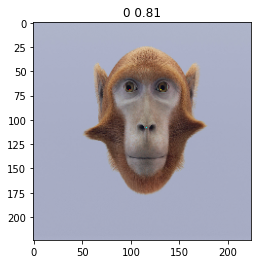

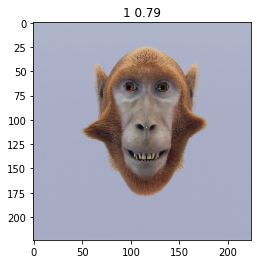

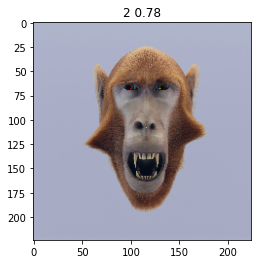

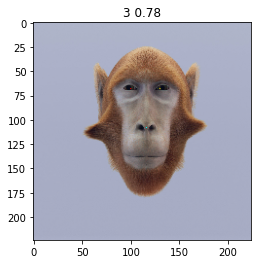

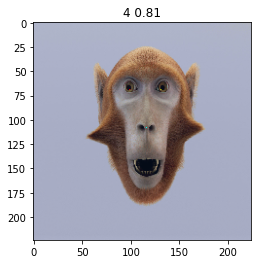

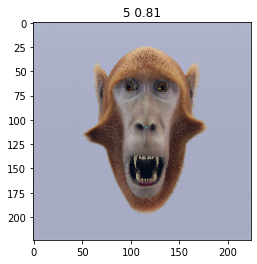

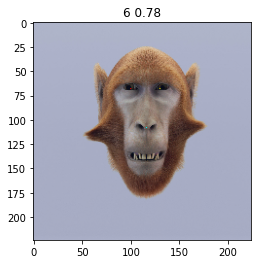

In [56]:
check_structure_face(test_fer_data_print, fr_lmk_pooled, ref_struct, verbose=True, do_plot=True)